In [2]:
import ee
import geopandas as gp
import matplotlib.pyplot as plt

ee.Initialize()

In [3]:
butte = gp.read_file("../shape/butte_gw_model.shp")
path_rows = gp.read_file("../shape/pathrow.shp")

In [4]:
prs = gp.sjoin(path_rows, butte, op='intersects', how = "inner")

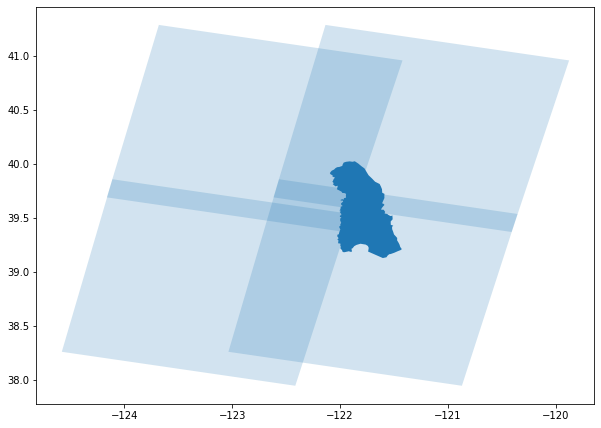

In [5]:
fig, ax = plt.subplots(figsize = (10, 8))

prs.plot(ax = ax, alpha = 0.2)
butte.plot(ax = ax)

In [6]:
prs.drop(prs.index[2], inplace = True)
prs.drop(prs.index[0], inplace = True)

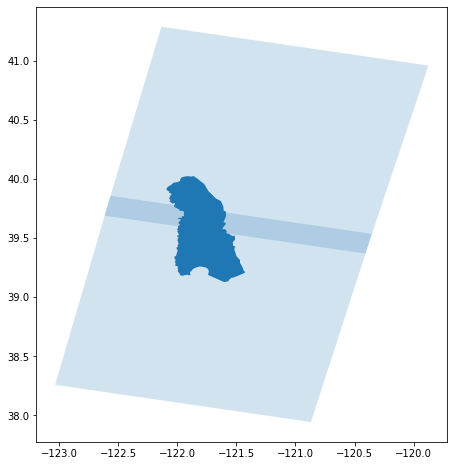

In [7]:
fig, ax = plt.subplots(figsize = (10, 8))

prs.plot(ax = ax, alpha = 0.2)
butte.plot(ax = ax)

In [8]:
# These are the path / rows 
prs['Name_left']

20567    44_33
20799    44_32
Name: Name_left, dtype: object

In [18]:
l81 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filter(ee.Filter.eq('WRS_PATH', 44)) .filter(ee.Filter.eq('WRS_ROW', 33))
l82 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filter(ee.Filter.eq('WRS_PATH', 44)) .filter(ee.Filter.eq('WRS_ROW', 32))


In [19]:
l1 = l81.getInfo()['features']
l2 = l82.getInfo()['features']

In [20]:
l8ids = []
for i in l1:
    l8ids.append(i['id'])
    
for i in l2:    
    l8ids.append(i['id'])

In [21]:
with open('l8_ids.txt', 'w') as filehandle:
    for i in l8ids:
        filehandle.write('%s\n' % i)

In [31]:
l71 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filter(ee.Filter.eq('WRS_PATH', 44)) .filter(ee.Filter.eq('WRS_ROW', 33))
l72 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filter(ee.Filter.eq('WRS_PATH', 44)) .filter(ee.Filter.eq('WRS_ROW', 32))


In [32]:
l3 = l71.getInfo()['features']
l4 = l72.getInfo()['features']

In [33]:
l7ids = []
for i in l3:
    l7ids.append(i['id'])
    
for i in l4:    
    l7ids.append(i['id'])

In [35]:
with open('l7_ids.txt', 'w') as filehandle:
    for i in l8ids:
        filehandle.write('%s\n' % i)